In [7]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [8]:
import tensorflow as tf
from typing import Iterable, List
import numpy as np
import math
from SpatialPooler import SpatialPooler
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from util.metrics import (
    get_mean_similiraty,
    similiraty_to_percent,
    get_similiraty,
    sp_stability,
)
from util.plots import plot_images, plot_image
from util.data import sample_class, encode_img, get_sp_sdr_test_set

<IPython.core.display.Javascript object>

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape

(60000, 28, 28)

<IPython.core.display.Javascript object>

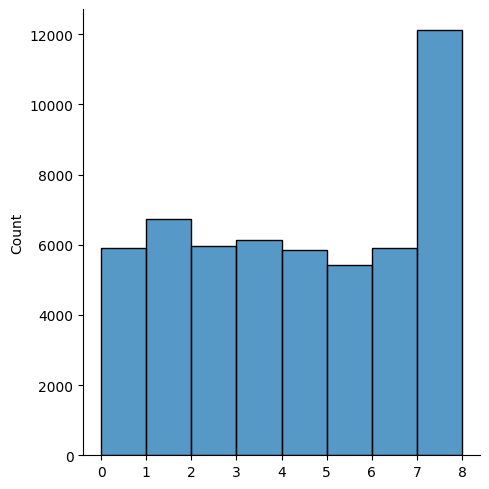

<IPython.core.display.Javascript object>

In [10]:
sns.displot(y_train, bins=(range(0, 9)))

In [11]:
inp_shape = x_train[0].shape
inp_shape

(28, 28)

<IPython.core.display.Javascript object>

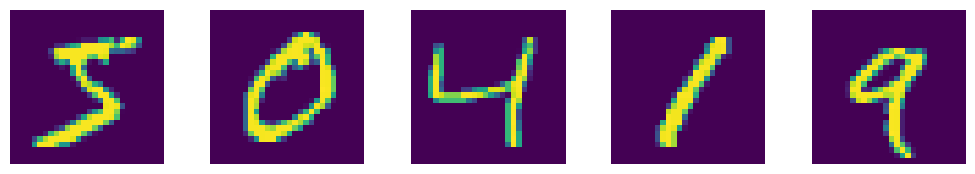

<IPython.core.display.Javascript object>

In [12]:
plot_images(x_train[:5])

In [13]:
COLUMN_SPARSITY = 0.2
COLUMN_DIM = (46, 46)

<IPython.core.display.Javascript object>

In [26]:
sp = SpatialPooler(
    input_dimension=inp_shape,
    column_dimension=COLUMN_DIM,
    connection_sparsity=0.4,
    permanence_threshold=0.5,
    stimulus_threshold=25.0,
    permanence_increment=0.1,
    permanence_decrement=0.02,
    column_sparsity=COLUMN_SPARSITY,
    potential_pool_radius=16,
)

<IPython.core.display.Javascript object>

In [27]:
samples = sample_class(x_train, y_train, 5, 5000, False)
samples = encode_img(samples)

<IPython.core.display.Javascript object>

In [35]:
for sample in tqdm(samples):
    sp.compute(sample, learn=True)
sp.save_state("sp_state")

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [36]:
ref_five, test_five = get_sp_sdr_test_set(sp, x_train, y_train, 5, False)

<IPython.core.display.Javascript object>

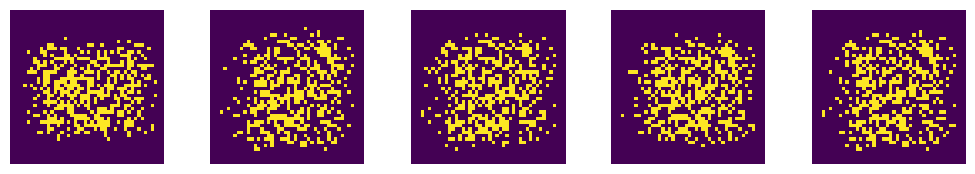

<IPython.core.display.Javascript object>

In [37]:
plot_images(ref_five.reshape((5, 46, 46)))

In [38]:
stability = sp_stability(sp, x_test, y_test, random=False)
stability.shape

similiraty scores: [341. 296. 323. 330. 297.]
mean similiraty: 317.4
similiraty in %: 75.00%


(10, 10)

<IPython.core.display.Javascript object>

<AxesSubplot:>

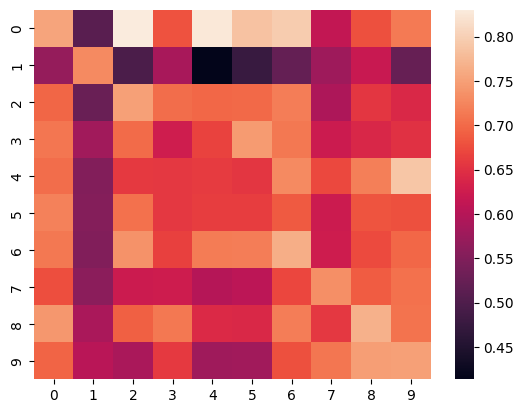

<IPython.core.display.Javascript object>

In [39]:
sns.heatmap(stability)

In [40]:
mean_stability = np.mean(np.diag(stability))
mean_stability

similiraty scores: [325. 344. 313. 329. 331.]
mean similiraty: 328.4
similiraty in %: 77.60%


<IPython.core.display.Javascript object>

In [59]:
sp.potential_pools[sp.potential_pools == True].shape

(662308,)

<IPython.core.display.Javascript object>

In [57]:
sp.permanences[sp.permanences > 0].shape

(484982,)

<IPython.core.display.Javascript object>

In [62]:
sp.connected_synapses[sp.connected_synapses == True].shape

(283693,)

<IPython.core.display.Javascript object>

In [13]:
sim = get_similiraty(ref_five, test_five)
mean_sim = get_mean_similiraty(ref_five, test_five)
sim_percent = similiraty_to_percent(mean_sim, COLUMN_SPARSITY, np.prod(COLUMN_DIM))

print(f"similiraty scores: {sim}")
print(f"mean similiraty: {mean_sim}")
print(f"similiraty in %: {sim_percent:.2%}")

similiraty scores: [293. 207. 256. 280. 194.]
mean similiraty: 246.0
similiraty in %: 58.13%


<IPython.core.display.Javascript object>

In [14]:
ref_six, test_six = get_sp_sdr_test_set(sp, x_train, y_train, 1, False)

<IPython.core.display.Javascript object>

In [15]:
sim = get_similiraty(ref_six, test_six)
mean_sim = get_mean_similiraty(ref_six, test_six)
sim_percent = similiraty_to_percent(mean_sim, COLUMN_SPARSITY, np.prod(COLUMN_DIM))

print(f"similiraty scores: {sim}")
print(f"mean similiraty: {mean_sim}")
print(f"similiraty in %: {sim_percent:.2%}")

similiraty scores: [245. 303. 289. 281. 246.]
mean similiraty: 272.8
similiraty in %: 64.46%


<IPython.core.display.Javascript object>

In [71]:
np.array(np.unravel_index(45, (32, 32))) / np.array([32, 32])

array([0.03125, 0.40625])

<IPython.core.display.Javascript object>

In [73]:
np.unravel_index(1, np.array([7]))

(1,)

<IPython.core.display.Javascript object>

In [83]:
int(3.999)

3

<IPython.core.display.Javascript object>

In [79]:
np.ravel_multi_index(np.array([2]), np.array([7]))

2

<IPython.core.display.Javascript object>

In [81]:
np.unravel_index(1, np.array([3]))

(1,)

<IPython.core.display.Javascript object>